# Shade Analysis via PVLib Modelling #

##### by David J. Florez Rodriguez (Stanford MS EE 2023),  Bennet E. Meyers-Im (Stanford EE Ph.D. Candidate)

This notebook models photovoltaic systems to estimate the amount of energy losses due to shade. This works also works to validate an algorithm that quantifies the aforementioned losses automatically.

1. First, we retrieve the solar power data and relevant metadata e.g.: latitude, longitude, specifications of the site inverter.

2. We analyze the data in a heat plot providing a general idea of shading and its distribution over the seasons. 

3. With the help of the PVLib library, we build a 'clear sky' model of what the solar system's power reading would resemble if weather and shading losses were absent. The 'clear sky' model is the shade-less version of the data from the site in question.

4. We remove days with clouding from the model. We also perform soiling correction--- countering the effect of gradual debris accumulation on panels. These are both in service of ensuring differences between the model and the data are mostly due to shade. We are now only looking at the 'clear sky' data.

5. Finally, we average daily energies of remaining days and average these energies for each calendar day over years of data. We then compare the energy of the model and the data taking their difference to be the energy lost due to shade. The agreement between this lost energy and the shade detection predicted by SLAC's algorithm is the metric that can validate the algorithm as we are now comparing a 'clear sky' model and 'clear sky' data.


## Anonimizing the notebook:
We include # some code was omitted for anonimity resposibilities # whenever notebook cells had to be edited to protect the privacy of our data providers and system owners for the studied sites

## Retrieving Data ##

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
import numpy as np
import boto3
import io
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from solardatatools import DataHandler, PolarTransform
from solardatatools.algorithms import soiling, ShadeAnalysis
from solardatatools.algorithms.shade import make_class_parameters

In [2]:
TIMESHIFT = 8
LEGEND = ['real','model']
PANEL_CELLS = 96
TILT = 19
ALTITUDE = 17
PANELS_PER_STRING = 8
STRINGS = 1
AZIMUTH = 180
START_IX = 0
END_IX = None

In [3]:
PANELS_PER_STRINGv2 = 6
STRINGSv2 = 1
AZIMUTHv2 = 90

Here we have an additional pair of parameters as this house has south facing and east facing panels.

The pandas storing and retrieving function accesses the cassandra database and stores a copy of each dataset used on the research machine.

In [4]:
def dataFetch(name):
# some code was omitted for anonimity resposibilities #
    df = None
    return df

In [5]:
site = None

In [6]:
df = dataFetch(site)

In [7]:
df = df.sort_values(by='time')

In [8]:
dh = DataHandler(df,convert_to_ts=True)

In [9]:
dh.run_pipeline(power_col=None,fix_shifts=False)
# some code was omitted for anonimity resposibilities #

total time: 28.36 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              12.82s
Cleaning                   0.83s
Filtering/Summarizing      14.72s
    Data quality           1.34s
    Clear day detect       1.11s
    Clipping detect        9.12s
    Capacity change detect 3.15s



The report below informed whether there were capacity changes or general quality issues in the data. To remove such hazards from the data, we tune the parameters START_IX and END_IX to include only data of relatively high quality 

In [10]:
dh.report()

Length:                3.57 years
Capacity estimate:     3.23 kW
Data sampling:         5 minute
Data quality score:    92.8%
Data clearness score:  45.2%
Inverter clipping:     False
Time shifts corrected: None
Time zone correction:  None


###  Heatmap

A plot of the power measurements of the solar system with the days of data collection on the x axis, the time of day on the y axis (increasing downwards) and the power scale displayed in color.

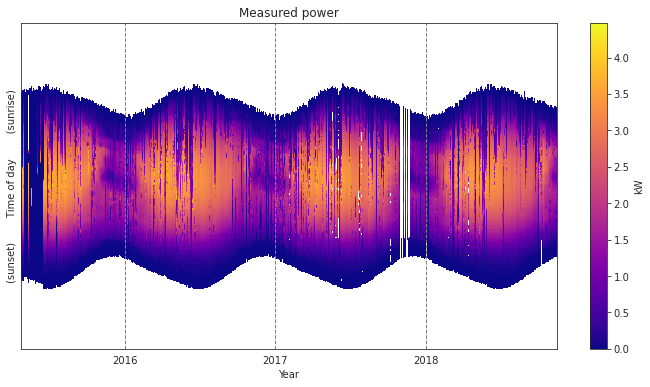

In [11]:
dh.plot_heatmap(matrix='raw');

## Retrieving Available Parameters ##

 ## Code below provided for demonstrational purposes. Sample locations below were picked by author and are entirely separate from the research and its dataset.

In [2]:
# some code was omitted for anonimity resposibilities #
sample = 'sample2'
sampleCoords = {'sample1':(37.42197222,-122.1711417, 147.62, 8),
				'sample2':(4.638255556,-74.07631111, 2915.8, 5),
				'sample3':(10.26938611,-67.98305, 488, 5)}

lat, lon, ALTITUDE, TIMESHIFT= sampleCoords[sample]

__[Google Earth Satellite View](https://earth.google.com/web/search/4.638255556,-74.07631111/@4.6382556,-74.0763111,2556.69223861a,1052.66882372d,35y,0h,45t,0r/data=ClwaMhIsGZf0QeCSjRJAIZi080fihFLAKhg0LjYzODI1NTU1NiwtNzQuMDc2MzExMTEYAiABIiYKJAkAzzCQKtxAQBGqL3pk9NtAQBnhHA6Z_nldwCG1QcdSIXpdwCgC)__

Note that this system has two azimuthal orientations.

## Initializing Model ##

PVLIB docs at https://pvlib-python.readthedocs.io/en/v0.9.0/modelchain.html guided early models

The altitude was retrieved from google earth.

In [14]:
loc = Location(float(lat),float(lon),tz='UTC',altitude= ALTITUDE)

The simplified solis model was chosen to model irradiance values. 

P. Ineichen, “A broadband simplified version of the Solis clear sky model,” Solar Energy, 82, 758-762 (2008).

In [15]:
clearSky = loc.get_clearsky(dh.data_frame[None].index.shift(TIMESHIFT, freq='h'), model='simplified_solis')

The SAPM (Sandia Array Performance Model) was selected to provide cell temperature.

https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.temperature.sapm_cell.html

## Importing temperature, panel and inverter data ##

#### Edit lines 10-11 in the cell below if looking to change the panel type used in modeling.

In [16]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['insulated_back_glass_polymer']
# some code was omitted for anonimity resposibilities #

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

panel = sandia_modules[None]
inverter = cec_inverters[None]

## Inverter selection requires user and is impactful in model's final accuracy ##

In [20]:
system1 = PVSystem(
    surface_tilt=TILT,
    surface_azimuth=AZIMUTH,
    modules_per_string=PANELS_PER_STRING, 
    strings_per_inverter=STRINGS,
    module_parameters=sandia_modules[panel],
    inverter_parameters=cec_inverters[inverter],
    temperature_model_parameters=temperature_model_parameters
)

model1 = ModelChain(system1, loc)

model1.run_model(weather =clearSky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

#### The cells above and below can make two simulations in the case of a location with panels facing multple directions

They are united as the datahandler is constructed

#### If only working with one model

Simply change 'model1' above to 'model'

In [21]:
system2 = PVSystem(
    surface_tilt=TILT,
    surface_azimuth=AZIMUTHv2,
    modules_per_string=PANELS_PER_STRINGv2, 
    strings_per_inverter=STRINGS,
    module_parameters=sandia_modules[panel],
    inverter_parameters=cec_inverters[inverter],
    temperature_model_parameters=temperature_model_parameters
)

model2 = ModelChain(system2, loc)

model2.run_model(weather =clearSky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Modelling ##

### Initial sample days in model (watts) ###

moving the timezone back so model hours match data

#### Run if doing two models

In [22]:
model1.ac.index = model1.ac.index.shift(-TIMESHIFT, freq='h')
model2.ac.index = model2.ac.index.shift(-TIMESHIFT, freq='h')
modelac = model1.ac+model2.ac

C:\Users\DJFRO\AppData\Roaming\Python\Python37\site-packages\pvlib\modelchain.py:499: pvlibDeprecationWarning: ModelChain.ac is deprecated and will be removed in v0.10. Use ModelChain.results.ac instead
  warnings.warn(msg, pvlibDeprecationWarning)


#### Run if doing one model

In [23]:
# model.ac.index = model.ac.index.shift(-TIMESHIFT, freq='h')
# modelac = model.ac

## Constructing DataHandler from model

In [24]:
modelDF = pd.DataFrame(modelac)/1000
modelDF.columns = ['ac']

modelDH = DataHandler(modelDF)

modelDH.run_pipeline(power_col='ac', correct_tz=True)

modelDH.report()

total time: 32.90 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              16.19s
Cleaning                   0.78s
Filtering/Summarizing      15.93s
    Data quality           1.36s
    Clear day detect       1.09s
    Clipping detect        9.63s
    Capacity change detect 3.85s

Length:                3.57 years
Capacity estimate:     3.11 kW
Data sampling:         5 minute
Data quality score:    100.0%
Data clearness score:  22.8%
Inverter clipping:     True
Time shifts corrected: None
Time zone correction:  None


### Data power matrix

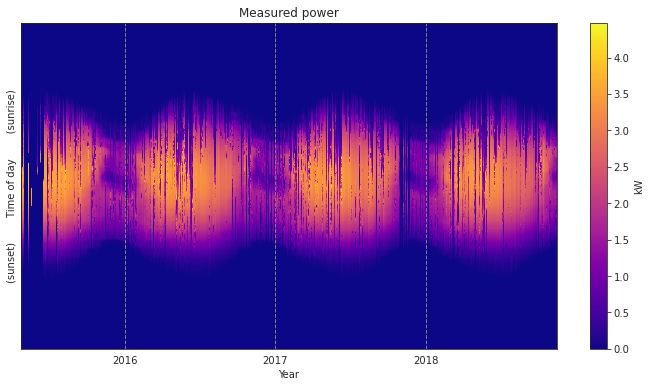

In [25]:
dh.plot_heatmap(matrix='filled',scale_to_kw=True);

### Model power matrix

As previously mentioned, the model is essnetially a perfect version of the existing data and allows one to better quantify how much power and energy could have been potentially obtained from the installed system.

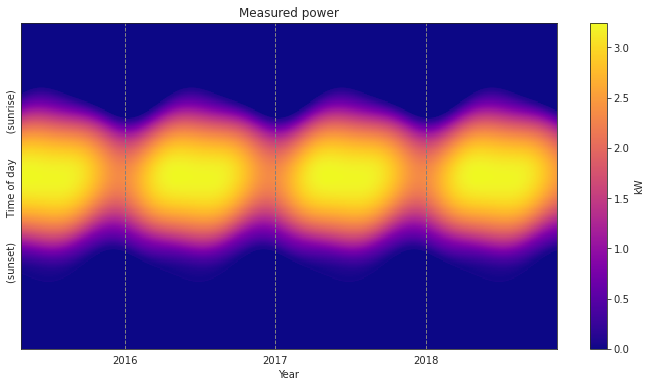

In [26]:
modelDH.plot_heatmap(matrix='filled',scale_to_kw=True);

## Comparisons

### Figure 9.:   Daily comparisons throught the year

internal metric for qualifying model match to data


MEAN ABS PERCENT ERROR
 0.08580884476905082 
MEAN ABS PERCENT ERROR



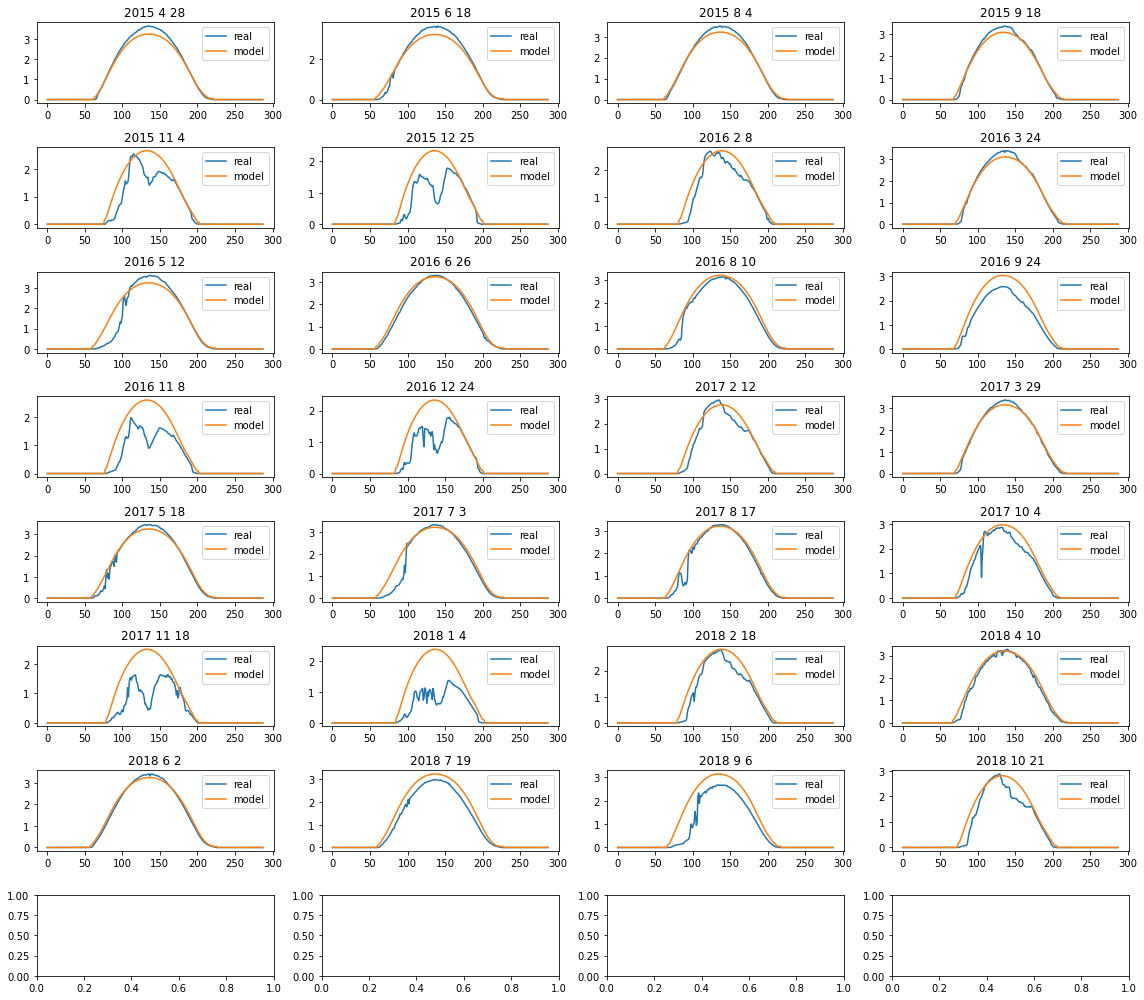

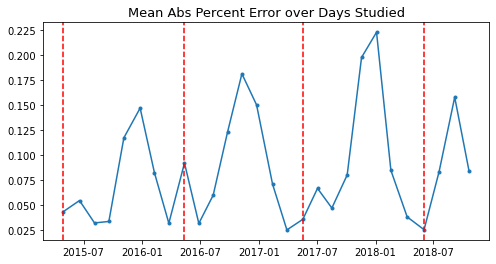

In [28]:
def daily_comparisons(dh,modelM):
    n_days = dh.filled_data_matrix.shape[1]
    j,pairs,max_all,mape=0,{},0,[]
    while j <n_days:
        clear = dh.daily_flags.clear[j]
        while not clear:
            j+=1
            clear = dh.daily_flags.clear[j]
        max_pwr = np.max(dh.filled_data_matrix[:,j])
        max_all = np.maximum(max_all,max_pwr)
        pairs[j] = ((dh.filled_data_matrix[:,j],modelM[:,j]))
        j+=45
    ############################### PLOTARRAY OF DAY COMPARISONS ###############################
    days = dh.day_index[list(pairs.keys())]
    plt.subplots(len(days)//4+1,4,figsize=(16,len(days)//2))
    for i in range(len(days)):
        k = list(pairs.keys())[i]
        plt.subplot(len(days)//4+1,4,i+1)
        plt.plot(dh.filled_data_matrix[:,k])
        plt.plot(modelM[:,k])
        plt.legend(LEGEND)
        plt.title(str(days[i].year)+' '
                  +str(days[i].month)+' '
                  +str(days[i].day))
    plt.tight_layout()
    ############################## COMPUTING SCALAR MAPE LOSS #################################   
    for i in list(pairs.keys()):
        pair = pairs[i]
        day_mask = (pair[1]>1e-4).astype(int)
        len_day = np.sum(day_mask)
        mape.append(np.sum(np.absolute(pair[0]*day_mask-pair[1]))/(len_day*max_all))
    mean_abs_prcnt_error = np.mean(np.asarray(mape))
    print('\nMEAN ABS PERCENT ERROR\n',mean_abs_prcnt_error,'\nMEAN ABS PERCENT ERROR\n')
    return days, mape

days, mape = daily_comparisons(dh,modelDH.filled_data_matrix)
############################# PLOT MAPE PER DAY #############################################
plt.figure(figsize=(8,4))
plt.plot(days,mape,marker='.', )
lines = days[::8]
for l in lines:
    plt.axvline(l,ls='--',color='r')
plt.title('Mean Abs Percent Error over Days Studied', fontsize=13)
plt.show()

## Day of Year Comparisons with Soiling Adjustment

We try various soiling algorithm instances by varying an internal parameter regulating stiffness of the soiling signal. Best instance is chosen by hand based on reasonable magnitudes and patterns that match with the natural cycles in soiling.

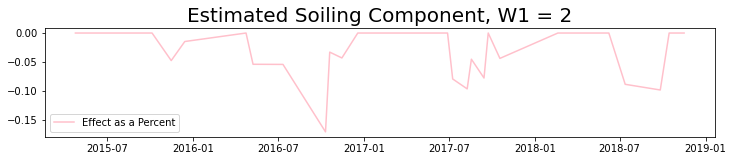

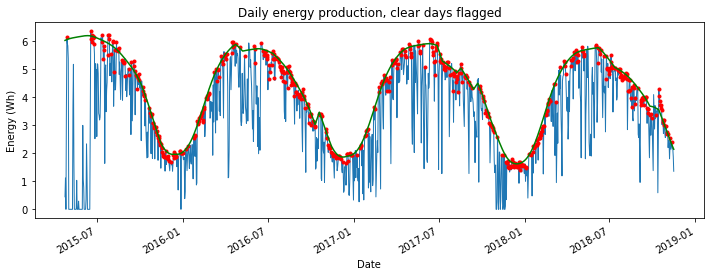

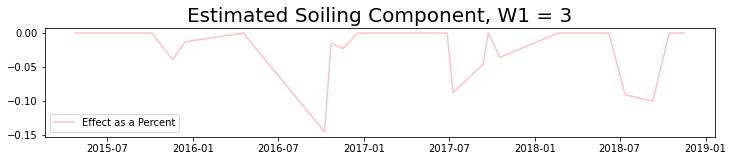

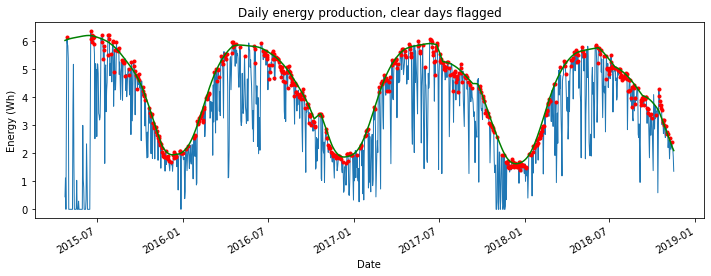

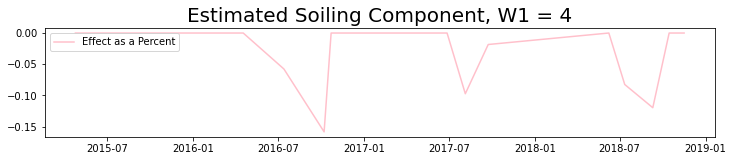

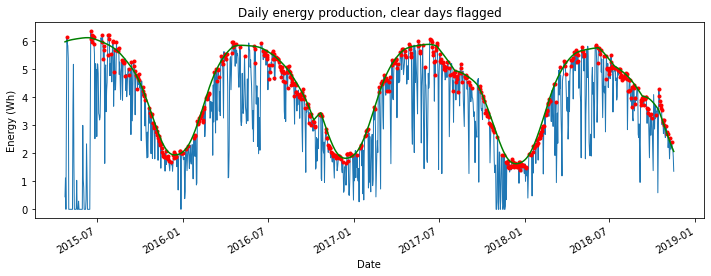

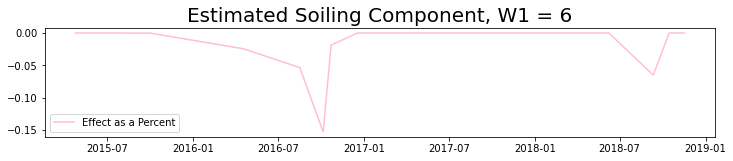

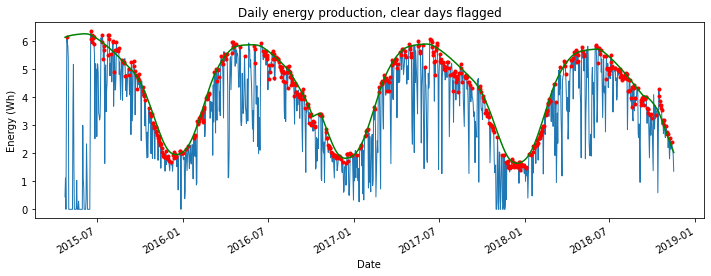

In [29]:
sa= soiling.SoilingAnalysis(dh)
soils = {}
for w1 in [2,3,4,6]: 
    sa.run(w1=w1)
    soils[w1] = sa.corr_filled_data_matrix
    plt.figure(figsize=(12,2))
    plt.plot(dh.day_index,sa.soiling_component, color='pink')
    plt.title('Estimated Soiling Component, W1 = '+str(w1),fontsize=20)
    plt.legend(['Effect as a Percent'])
    plt.show()
    fig = dh.plot_daily_energy(flag='clear',figsize=(12,4))
    plt.plot(dh.day_index,(sa.seasonal_component + sa.soiling_component +
                           sa.degradation_component) * sa.scaling,color='g');

In [30]:
soil_correct = soils[4]

In [31]:
def doy_energy_comparison(data_dh,model_dh, scale = '' ,
            soil_corrected_filled_matrix = None, plotless=False,
                         save_plot=None):
    '''
    For scale, use 'cap' for capacity scaling or 'max' for maximum 
    value scaling WITHOUT soiling correction. To use WITH soil correction,
    use 'cap soil', 'max soil', 'soil' for the various scaling options
    
    plotless prevent a plot from being printed
    
    data_dh and model_dh are the solar_data_tools datahandlers
    
    if using soiling correction, must include the 
    
    
    '''
    ### Getting the daily energy of the model, the data and the difference
    filled_model_matrix = model_dh.filled_data_matrix
    T_interval = dh.data_sampling
    soil_tag = 'Raw'
    if 'soil' not in scale:
        matrix = data_dh.filled_data_matrix
    else:
        matrix = soil_corrected_filled_matrix
        soil_tag = ' (w/ soiling correction)'
    daily_energy_data = np.sum(matrix,
                               axis=0) * T_interval / 60 
    daily_energy_model = np.sum(filled_model_matrix,
                                axis=0) * T_interval / 60
    daily_energy_df = pd.DataFrame(data={'modelled': daily_energy_model, 
                                         'measured': daily_energy_data,
                                         'difference':daily_energy_model-daily_energy_data,
                                         'doy': data_dh.day_index.dayofyear},
                                   index=data_dh.day_index)
    daily_energy_df.iloc[~data_dh.daily_flags.clear, :2] = np.nan
    daily_energy_df = daily_energy_df.dropna()
    
    ###
    ### compacting these values for doy comparisons
    
    year = daily_energy_df.groupby('doy')
    seasonal_energy_comparison = year.mean()
    plot_title = 'Annual Energy Comparison '
    
    
    if 'max' in scale:
        #getting the ratio
        max_meas = np.max(seasonal_energy_comparison['measured'])
        arg_max = np.argmax(seasonal_energy_comparison['measured'])
        max_model_at_max_meas = seasonal_energy_comparison.iloc[arg_max, 0]
        model_ratio = max_meas / max_model_at_max_meas
        
        #applying it
        seasonal_energy_comparison['modelled'] *= model_ratio
        seasonal_energy_comparison['difference'] = (
            seasonal_energy_comparison['modelled']-
            seasonal_energy_comparison['measured'])
        
        plot_title = 'Annual Energy Comparison Max Scaled'
    elif 'cap' in scale:
        cap_ratio = dh.capacity_estimate/model_dh.capacity_estimate
        seasonal_energy_comparison['modelled'] *= cap_ratio
        seasonal_energy_comparison['difference'] = (
            seasonal_energy_comparison['modelled']-
            seasonal_energy_comparison['measured'])
        plot_title = 'Annual Energy Comparison Capacity Scaled'
    
    if not plotless:
        seasonal_energy_comparison.plot();
        if save_plot != None:
            plt.title(save_plot)
            plt.savefig('pics/'+save_plot)
        plt.title(plot_title+soil_tag)
        
            
        
        plt.show()

    #let's get that loss
    loss = np.clip(seasonal_energy_comparison['difference'],0,np.inf)
    sumLoss = np.sum(loss)
    return (sumLoss, loss,
           seasonal_energy_comparison['modelled'])

### Simulation Error

Note that 'diff' below is simply the eroor between the model and the data. This is what we believe to be the loss due to shade.

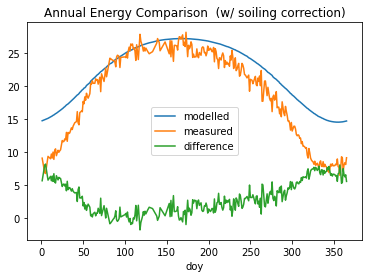

In [32]:
sum_error_soil,error_soil,clear_model_soil =(
        doy_energy_comparison(dh,modelDH,scale = 'soil',
        soil_corrected_filled_matrix=soil_correct) )